In [26]:
import pandas as pd
import random
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Union
from dataclasses import dataclass
from scipy.spatial import distance

In [28]:
result_path = "/home/morita/Radiation_distribution_machine_learning/data/result1_test.csv"
df = pd.read_csv(result_path, header=None)
df.columns = ['x', 'y', 'z', 'value']
print(df)

        x    y    z        value
0     0.5  0.5  0.0  1531.771118
1     1.5  0.5  0.0  1827.572510
2     2.5  0.5  0.0  1218.727173
3     3.5  0.5  0.0  1015.480652
4     4.5  0.5  0.0   749.622131
..    ...  ...  ...          ...
135   9.5  9.5  0.0    90.363411
136  10.5  9.5  0.0    81.334854
137  11.5  9.5  0.0    68.844215
138  12.5  9.5  0.0    58.700428
139  13.5  9.5  0.0    50.448380

[140 rows x 4 columns]


In [29]:
@dataclass
class Source:
    """
    Create point radiation source.

    Examples
    --------
    >>> Source([1, 2, 3], 2.0)
    Source(loc=[1, 2, 3], intensity=2.0)
    """

    #: Location of the radiation source such that [x, y, z] [m].
    loc: List[float]
    #: Intensity of the radiation source [MBq]. (default is 1.0)
    intensity: float = 1.0

In [12]:
class World(object):
    """
    Create world for adding radiation sources and detectors.
    """
    def __init__(self):
        self.sources: List[Source] = []

    def __repr__(self) -> str:
        repr_str = f"{self.__class__}: contains {len(self.sources)} sources.\n"
        src_str = ",\n ".join([str(it) for it in self.sources])
        repr_str = f"{repr_str}[\n {src_str}\n]"
        return repr_str

    def add_source(self, source: Source):
        """
        Add radiation point source.

        Parameters
        ----------
        source: Source
            Radiation point source.
        """
        self.sources.append(source)

    def visualize_world(
        self,
        figsize: Tuple[float, float] = (8, 8),
        plotsize: float = 10,
    ) -> plt.Axes:
        """
        Visualize radiation sources and detectors in world (X-Y plane).

        Parameters
        ----------
        detectors: List[Detector]
            List of detectors to be visualized. (default is [])
        figsize: tuple(float, float)
            figsize for plot.
        plotsize: float
            Plot in xy plane [-plotsize, plotsize] x [-plotsize, plotsize]

        Returns
        -------
        ax: plt.Axes
            Matplotlib axes
        """

        # Setup plot area
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(
            [plotsize, plotsize, -plotsize, -plotsize],
            [plotsize, -plotsize, plotsize, -plotsize],
            "wd",
        )
        ax.plot([0], [0], "rd")
        ax.set_aspect("equal")
        ax.set_title("X (horizontal), Y (vertical), Origin (red dot)")

        # Visualize sources
        x = []
        y = []
        c = []
        for src in self.sources:
            x.append(src.loc[0])
            y.append(src.loc[1])
            c.append(src.intensity)

        sc = ax.scatter(x, y, s=100, c=c, cmap=plt.cm.jet)
        _ = fig.colorbar(sc, orientation="horizontal")

        return ax

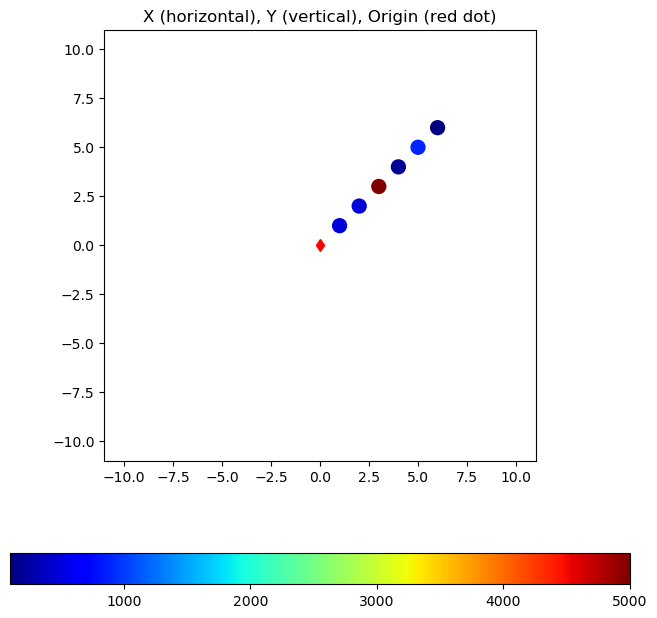

In [13]:
# Construct world
world = World()
world.add_source(Source(loc=np.array([1,1,0]), intensity=500))
world.add_source(Source(loc=np.array([2,2,0]), intensity=500))
world.add_source(Source(loc=np.array([3,3,0]), intensity=5000))
world.add_source(Source(loc=np.array([4,4,0]), intensity=200))
world.add_source(Source(loc=np.array([5,5,0]), intensity=900))
world.add_source(Source(loc=np.array([6,6,0]), intensity=100))

ax = world.visualize_world()

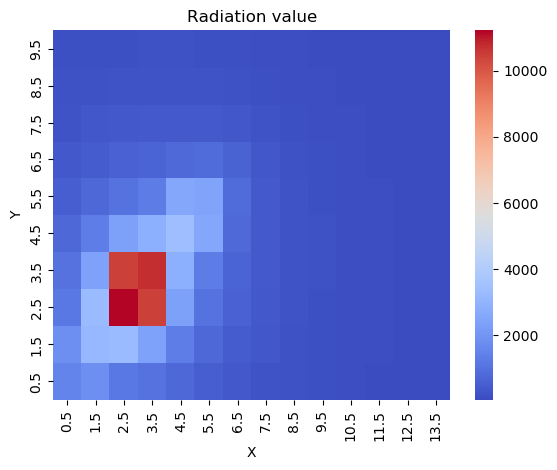

In [24]:
heatmap = df.pivot('y', 'x', 'value')
sns.heatmap(heatmap, cmap='coolwarm')
plt.gca().invert_yaxis() #invert y axis
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Radiation value')
plt.show()
    

In [ ]:
b_measure = 
x_b = np.array([it.loc for it in detectors])
assert x_b.shape[0] == len(b_measure), 'Number of measument should be equal to number of position'

In [25]:
def score_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    score = np.sum(b_measure*np.log(b_ave))-np.sum(b_ave)
    return score

def grad_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    grad_tmp = (b_measure/b_ave)[:,np.newaxis]*A
    grad = grad_tmp.sum(axis=0) - A.sum(axis=0)
    return grad

## Optimization
### Gradient decent

In [ ]:
# initial guess for radiation distribution
M = x_q.shape[0]
q_max = 10
q_init = 1/q_max
q = np.array([q_init]*M)
# b_ave = A.dot(q)
# plt.imshow(b_ave.reshape(div_num, div_num))

optim_factor = 0.00002
init_score = score_func(q)
print(f'initial score:{init_score}')

In [ ]:
for i in range(1, 800):
    q_diff = grad_func(q)
    q += optim_factor*q_diff

    # bound > 0
    q[q<0]=0.0000001

    score = score_func(q)
    if i%100==0:
        plt.figure()
        plt.title(f'iter:{i} score:{score} q_max:{q.max():.3}, q_min:{q.min():.3}')
        plt.imshow(q.reshape(source_div_num, source_div_num))

## SLSQP
Sequential (least-squares) quadratic programming (SQP)